# Flight Data Exploration

## Preliminary Wrangling

This document explores a dataset containing flight departure & arrival times, cancellations and delays for 2008. 

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sb
%matplotlib inline

In [3]:
df = pd.read_csv('data/flight_data.csv')


In [4]:
#rename columns so they are easier to interpret 

df = df.rename(columns = {'CRSDepTime':'sched_depart',
                    'DepTime':'actual_depart',
                    'ArrTime':'actual_arrival',
                    'CRSArrTime':'sched_arrival'
                    })



In [5]:
#replace encodings with actual values 

df.CancellationCode = df.CancellationCode.replace({'A':'carrier',
                                                   'B':'weather',
                                                  'C':'NAS',
                                                  'D':'security'})



In [6]:
#change datatype to string 

df.DayOfWeek = df.DayOfWeek.astype('str')
# df.Month = df.Month.astype('str')

#replace encodings with actual values 

df.DayOfWeek = df.DayOfWeek.replace({'1':'Monday',
                     '2':'Tuesday',
                     '3':'Wednesday',
                     '4':'Thursday',
                     '5':'Friday',
                     '6':'Saturday',
                     '7':'Sunday'})



In [7]:
#put days of week in order

ordinal_var_dict = {'DayOfWeek': ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']}
for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)
    
    

In [8]:
#drop columns not necessary for analysis
df = df.drop(columns=['Year','FlightNum','TailNum','ActualElapsedTime','CRSElapsedTime','Diverted'])


In [9]:
df['total_delay']= df['CarrierDelay']+df['WeatherDelay']+df['SecurityDelay']+df['LateAircraftDelay']

In [10]:
#add dummy index column to create unique identifier for melt function 

df['new_col'] = range(1, len(df) + 1)

In [11]:
df_new = pd.melt(df, 
                 id_vars=['Month','DayofMonth','DayOfWeek','actual_depart','sched_depart','actual_arrival','sched_arrival','UniqueCarrier','AirTime','ArrDelay','DepDelay','Origin','Dest','Distance','TaxiIn','TaxiOut','Cancelled','CancellationCode','total_delay','new_col'],
                 value_vars = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay','LateAircraftDelay'],
                 var_name='types',value_name='delay_type')
                          
                          
                

In [12]:
#sort values by type and then drop duplicates
df_new = df_new.sort_values('delay_type').drop_duplicates('new_col', keep = 'last')

In [13]:
#drop unnecessary column
df_new = df_new.drop(columns=['delay_type','new_col'])

In [14]:
df_new.head()

,Month,DayofMonth,DayOfWeek,actual_depart,sched_depart,actual_arrival,sched_arrival,UniqueCarrier,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,total_delay,types
1204019,3,11,Tuesday,1425.0,1415,1525.0,1510,WN,48.0,15.0,10.0,RNO,OAK,180,4.0,8.0,0,NaN,10.0,CarrierDelay
1500625,3,31,Monday,1525.0,1515,1720.0,1705,DL,92.0,15.0,10.0,CVG,BDL,661,8.0,15.0,0,NaN,10.0,CarrierDelay
30702618,5,15,Thursday,1805.0,1755,2129.0,2114,US,306.0,15.0,10.0,PHL,SFO,2521,42.0,36.0,0,NaN,10.0,LateAircraftDelay
28658446,2,6,Wednesday,1605.0,1555,1710.0,1655,WN,44.0,15.0,10.0,STL,MCI,237,7.0,14.0,0,NaN,10.0,LateAircraftDelay
20260859,11,6,Thursday,1426.0,1416,1636.0,1621,EV,42.0,15.0,10.0,BNA,ATL,214,5.0,23.0,0,NaN,10.0,NASDelay


### What is the structure of your dataset?

There are ~7million records in the dataset. Most of the variables are times stored as integers, with some categorical variables (cancellation codes, carrier codes, days of week). 

### What is/are the main feature(s) of interest in your dataset?

I'm most interested in determining the impact of different features on delays. I'd also like to look at which airlines have the most frequent / longest delays, and whether delays are correlated with the seasons, day of the week, departure times, airlines etc. Therefore, a created a new df where delays are > 0 to exclude records without delays. 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I expect there will be greater delays during winter, weekends, and for certain airlines. 

## Univariate Exploration

I'll start by looking at the distribution of the length of delays, as well as frequencies for delays by day of week, month & airlines.

In [15]:
#create df to only include delays (exlude where delays are 0)
df_delays = df.loc[df['total_delay']>0]

In [16]:
df_delays.head()

,Month,DayofMonth,DayOfWeek,actual_depart,sched_depart,actual_arrival,sched_arrival,UniqueCarrier,AirTime,ArrDelay,...,TaxiOut,Cancelled,CancellationCode,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,total_delay,new_col
4,1,3,Thursday,1829.0,1755,1959.0,1925,WN,77.0,34.0,...,10.0,0,NaN,2.0,0.0,0.0,0.0,32.0,34.0,5
6,1,3,Thursday,1937.0,1830,2037.0,1940,WN,230.0,57.0,...,7.0,0,NaN,10.0,0.0,0.0,0.0,47.0,57.0,7
11,1,3,Thursday,1644.0,1510,1845.0,1725,WN,107.0,80.0,...,8.0,0,NaN,8.0,0.0,0.0,0.0,72.0,80.0,12
16,1,3,Thursday,1452.0,1425,1640.0,1625,WN,213.0,15.0,...,8.0,0,NaN,3.0,0.0,0.0,0.0,12.0,15.0,17
18,1,3,Thursday,1323.0,1255,1526.0,1510,WN,110.0,16.0,...,9.0,0,NaN,0.0,0.0,0.0,0.0,16.0,16.0,19


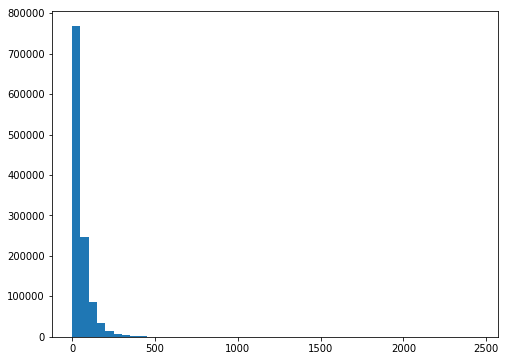

In [17]:
#delays are right skewed with the majority less than 20mins
bins = np.arange(0,df_delays.total_delay.max()+1,50)
plt.figure(figsize = [8,6])
plt.hist(df_delays.total_delay,bins=bins);



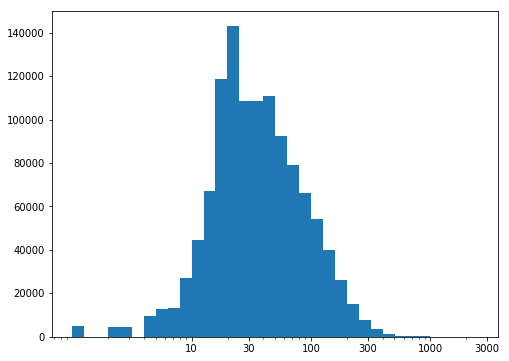

In [18]:
#try log transformation as long tail in distribution

bins = 10 ** np.arange(0,np.log10(df_new.total_delay.max())+.1,.1)

plt.figure(figsize = [8,6])
plt.hist(df_new.total_delay,bins=bins)
plt.xscale('log')
tick_locs = [10, 30, 100, 300, 1000, 3000]
plt.xticks(tick_locs, tick_locs);


Using a log transform of the x axis can see that delays are more normally uni-modally distributed. Delays are slightly right skewed, meaning delays are most commonly shorter in duration, with an average around 25-30 mins. There are a few outliers (max delay = 2436 mins) which skew the data to the right 


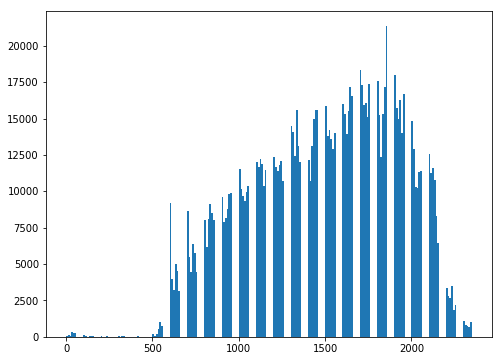

In [19]:
#delayed flights departure times distribution

bins = np.arange(0,df_delays.sched_depart.max(),10)

plt.figure(figsize=[8,6])
plt.hist(df_delays.sched_depart, bins=bins);


Can see that delayed flight departure times are slightly left skewed, with majority of delays falling between 5am and 8pm (data is formatting as HHMM so 500 = 5:00, 2000 = 20:00). 

In some cases the departures are rounded to the nearest 30 min interval so can see there are some gaps in the histogram

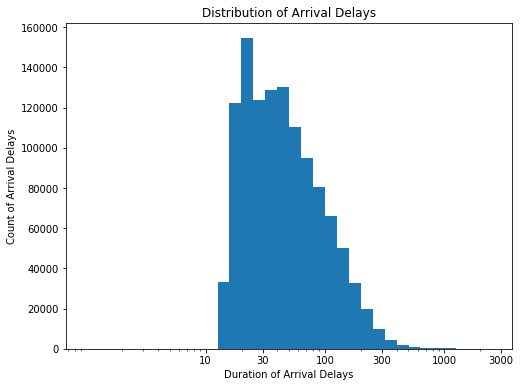

In [20]:
#distribution of arrival delays

bins = 10 ** np.arange(0,np.log10(df_delays.ArrDelay.max())+.1,.1)

plt.figure(figsize = [8,6])
plt.hist(df_delays.ArrDelay,bins=bins)
plt.xscale('log')
tick_locs = [10, 30, 100, 300, 1000, 3000]
plt.xticks(tick_locs, tick_locs)
plt.xlabel('Duration of Arrival Delays')
plt.ylabel('Count of Arrival Delays')
plt.title('Distribution of Arrival Delays');


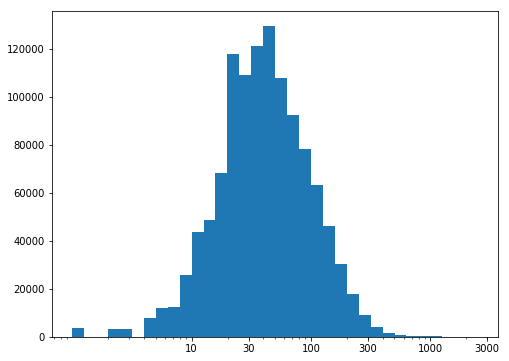

In [21]:
#distribution of departure delays

bins = 10 ** np.arange(0,np.log10(df_delays.DepDelay.max())+.1,.1)

plt.figure(figsize = [8,6])
plt.hist(df_delays.DepDelay,bins=bins)
plt.xscale('log')
tick_locs = [10, 30, 100, 300, 1000, 3000]
plt.xticks(tick_locs, tick_locs);

It is interesting that there do not seem to be any arrival delays under 10 mins of length. The arrival delay data is definitely right-skewed, while the departure delays data seems to be more evenly distributed. 

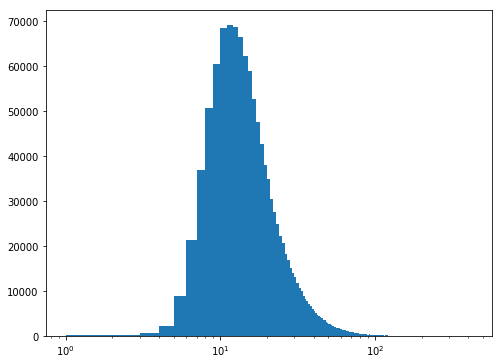

In [22]:
#taxi in and out time for delays
bins = np.arange(0,df_delays.TaxiOut.max()+1,1)

plt.figure(figsize=[8,6])
plt.hist(data = df_delays, x='TaxiOut', bins=bins);
plt.xscale('log')




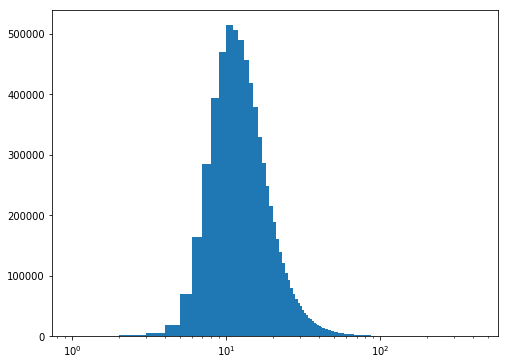

In [23]:
#taxi in and out time for all data
bins = np.arange(0,df.TaxiOut.max()+1,1)

plt.figure(figsize=[8,6])
plt.hist(data = df, x='TaxiOut', bins=bins);
plt.xscale('log')


Can see that taxi-out times are normally distributed, unimodal, and right-skewed. Taxi-out times for all flights and delayed flights are similar, with the delays chart showing a less prominent/sharp right-skew than the all-data chart. 

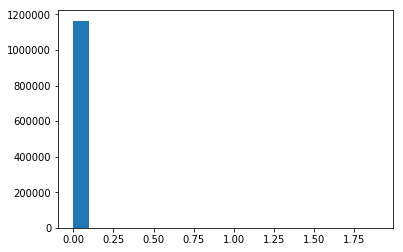

In [24]:
#look at distribution of cancelled flights for delayed flights vs. not delayed
bins = np.arange(0,2,.1)
plt.hist(data=df_delays,x='Cancelled',bins=bins);


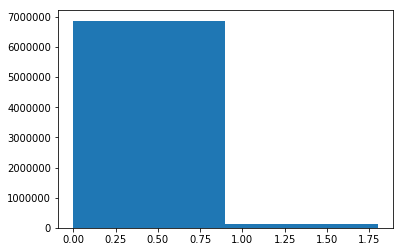

In [25]:
bins = np.arange(0,2,.9)
plt.hist(data=df,x='Cancelled',bins=bins);

In [26]:
percent_cancelled = sum(df.Cancelled)/len(df) * 100
percent_cancelled


1.9606181580797428

Can see that no delayed flights from df_delays were cancelled. This must mean the flight delay is not recorded if the flight is eventually cancelled. Of the total dataset, can see that only 1.96% of flights were cancelled. 

In [27]:
#create new df of origins with value counts > 15,0000 to analyze most frequent origin of delays

df_origin = df_delays.groupby("Origin").filter(lambda x: len(x) > 15000)

#do the same for destinations

df_dest = df_delays.groupby("Dest").filter(lambda x: len(x) > 15000)





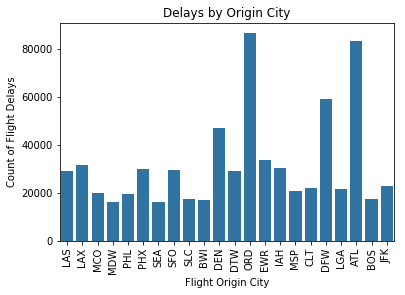

In [30]:
base_color = sb.color_palette()[0]

sb.countplot(data = df_origin, x='Origin', color=base_color)
plt.xticks(rotation=90)
plt.xlabel('Flight Origin City')
plt.ylabel('Count of Flight Delays')
plt.title('Delays by Origin City');


Can see that majority of delays are with flights originating from Atlanta (ATL) and Chicago (ORD), followed by Dallas (DFW). 

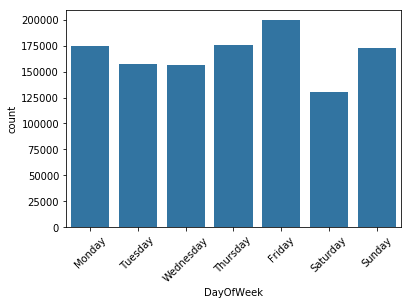

In [32]:
base_color = sb.color_palette()[0]

sb.countplot(data = df_delays, x='DayOfWeek', color=base_color)
plt.xticks(rotation=45);



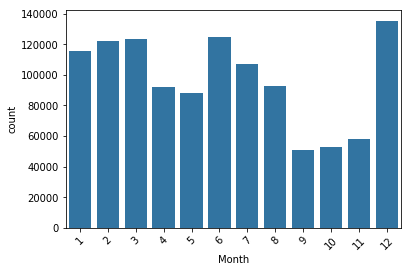

In [33]:
base_color = sb.color_palette()[0]

sb.countplot(data = df_delays, x='Month', color=base_color)
plt.xticks(rotation=45);



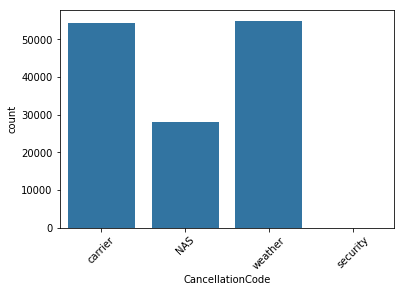

In [34]:
base_color = sb.color_palette()[0]
sb.countplot(data=df,x='CancellationCode', color=base_color)
plt.xticks(rotation=45);


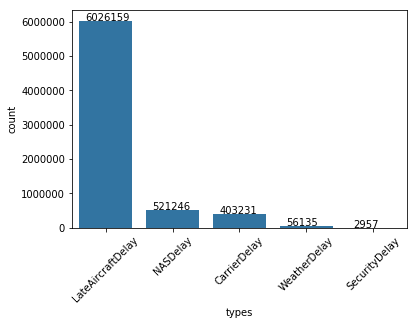

In [35]:
# labels = ['6,026,159','521,246','403,231','56,135','2,957']

gen_order = df_new.types.value_counts().index

base_color = sb.color_palette()[0]
ax = sb.countplot(data=df_new,x='types', color=base_color, order= gen_order)
plt.xticks(rotation=45)
for p, label in zip(ax.patches, df_new["types"].value_counts()):
    ax.annotate(label, (p.get_x()+.1, p.get_height()+0.15));

Can see that delays occur most frequently on Fridays, and in December. This is not surprising given I would expect the volume of flights to be high on Fridays (people taking off for the weekend) and poor weather to be a factor contributing to December delays. We will investigate further during bi-variate and multi-variate analysis.

Also see that most cancellation codes are due to weather and carrier issues, with very few related to security. 

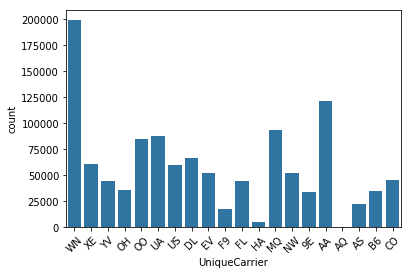

In [36]:
base_color = sb.color_palette()[0]
sb.countplot(data=df_delays,x='UniqueCarrier', color=base_color)
plt.xticks(rotation=45);


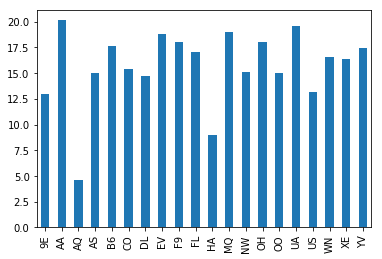

In [37]:
#number of delays as a % of total flights by carrier

total_flights = df.UniqueCarrier.value_counts()
delayed_flights = df_delays.UniqueCarrier.value_counts()
percent_delayed = (delayed_flights/total_flights)*100

base_color = sb.color_palette()[0]
percent_delayed.plot(kind='bar',color=base_color);



Can see that 'WN' (Southwest airlines) and 'AA' (american airlines) carrier codes have most frequent delays, while airline AQ (aloha airlines) seems to have the fewest delays. 

Looking at proportionate delays, AA is still one of the worst offenders, along with OH (Ohio Airline) 

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The duration of delays variable had a wide range of values so needed to apply a log transformation. They were some outliers of unusually long delays which caused the data to be right skewed. 

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

I created a new column that sums the 4 different delay type columns to get the total delay time. I also changed some of the variable names from number to actuals (i.e. 1 = Monday) in order to make interpreting the data easier. 

### Bivariate Exploration

I am going to start by looking at correlations between delay duration and other variables. 

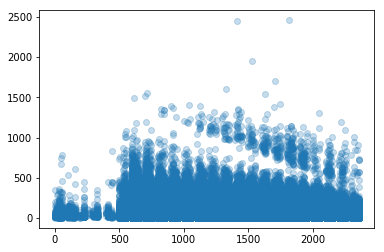

In [38]:
#departure time vs. delay

plt.scatter(data=df_delays, x='sched_depart' ,y='total_delay',alpha=.25);


Appears to be somewhat of a negative correlation between delay durations and the time of day (i.e. as it gets later in the day, delays get shorter). Log transformation of the x-axis did not help this analysis. 

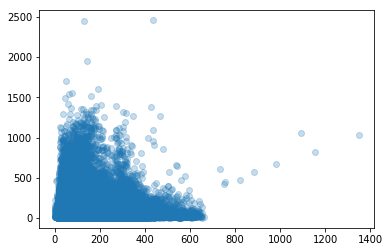

In [39]:
#airtime vs delays

plt.scatter(data=df_delays, x = 'AirTime', y='total_delay',alpha=.25);

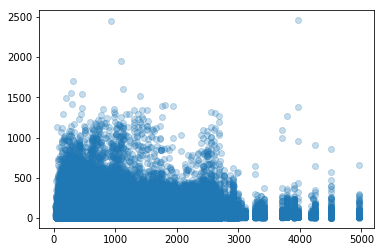

In [40]:
#flight distance vs delays

plt.scatter(data=df_delays, x = 'Distance', y='total_delay',alpha=.25);

It appears that delays are longer for shorter airtime flights, while flight distance has less of a correlation with delays. Can see there are some striations with the flight distance data as distances increase (this makes sense as the flights are likely over bodies of water). 

/Users/erinhayes/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


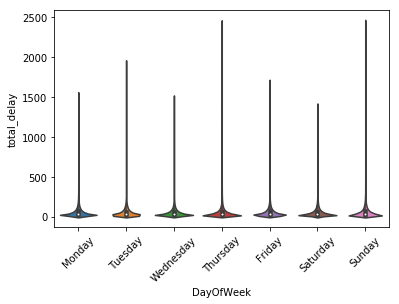

In [41]:
sb.violinplot(data=df_delays,y='total_delay', x='DayOfWeek')
plt.xticks(rotation=45);


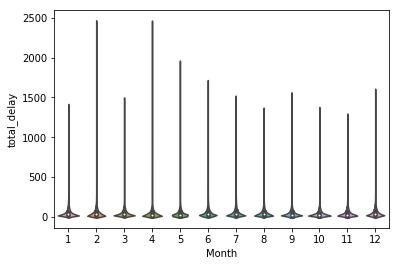

In [42]:
sb.violinplot(data = df_delays, x='Month',y='total_delay')



No interesting insights regarding correlation between delay durations and the day of week or the month. Can see the quartiles are all very similar regardless of day/month, but the greatest outliers for delay times exist for 2 & 4 (February and April) and on Thursdays. 

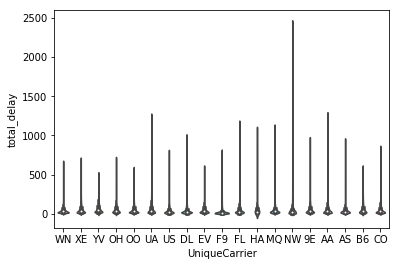

In [43]:
sb.violinplot(data = df_origin, x='UniqueCarrier',y='total_delay')


### Multivariate Exploration

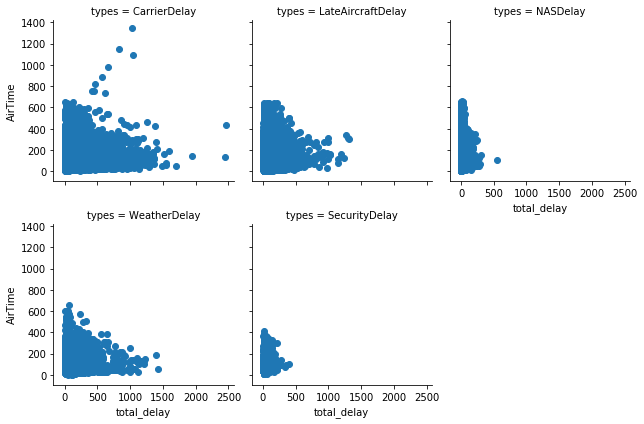

In [44]:
g = sb.FacetGrid(data=df_new, col='types',col_wrap=3)
g.map(plt.scatter, 'total_delay','AirTime');

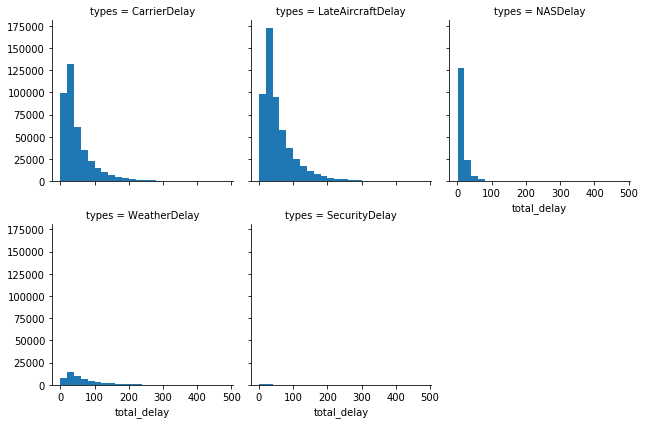

In [45]:
bins = np.arange(0.1,500,20)
g = sb.FacetGrid(data=df_new, col='types', col_wrap=3)
g.map(plt.hist, 'total_delay', bins=bins);

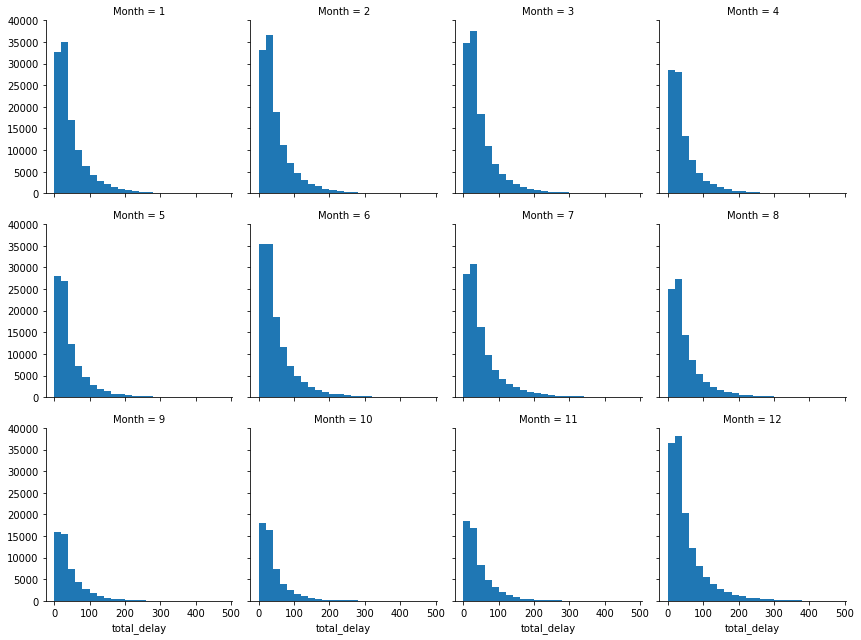

In [46]:
#distribution of total delays by month

bins = np.arange(0.1,500,20)
g = sb.FacetGrid(data=df_new, col='Month', col_wrap=4)
g.map(plt.hist, 'total_delay',bins=bins);

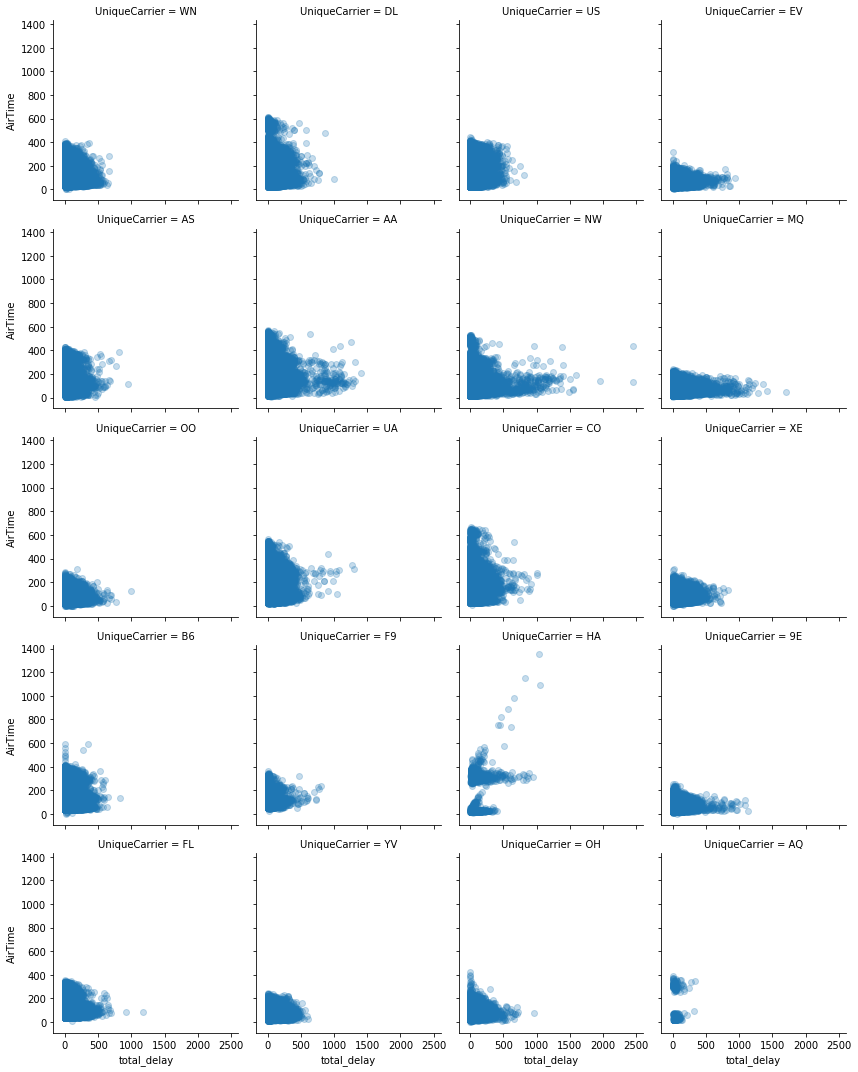

In [47]:
g = sb.FacetGrid(data=df_new, col='UniqueCarrier', col_wrap=4)
g.map(plt.scatter, 'total_delay','AirTime',alpha= .25);

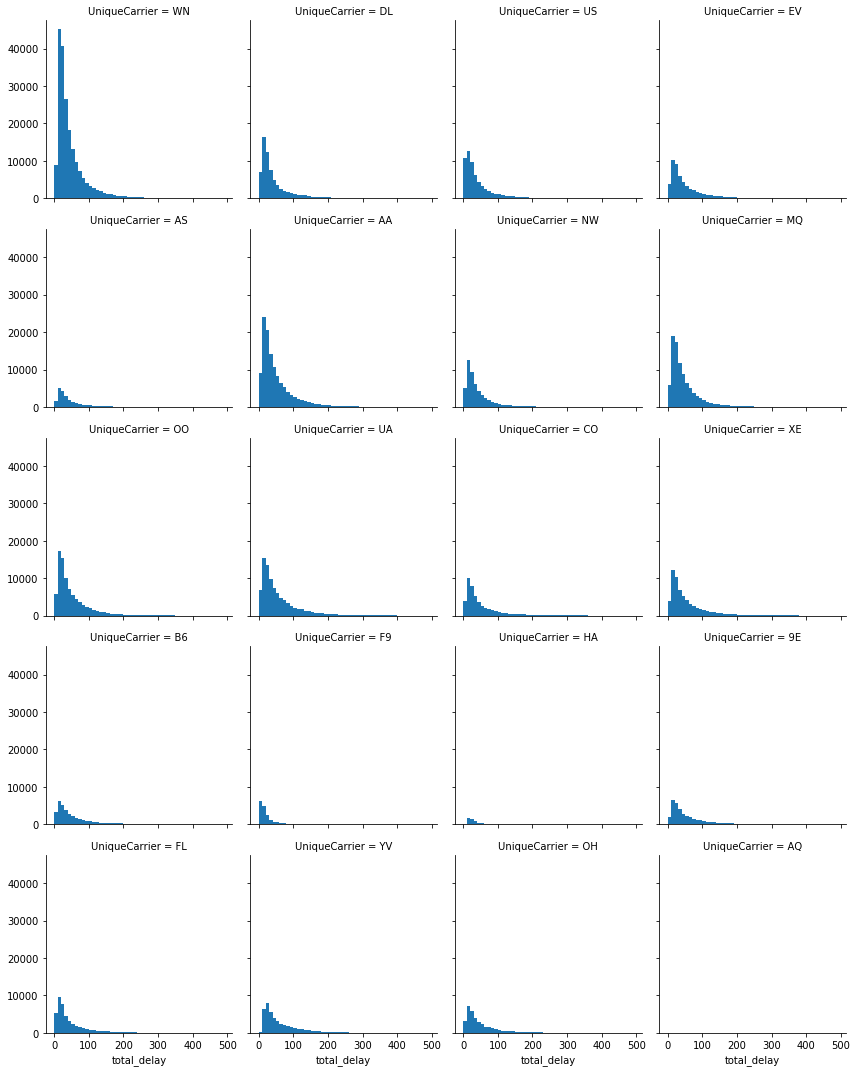

In [48]:
#distribution of delays by carrier

bins = np.arange(0.1,500,10)
g = sb.FacetGrid(data=df_new, col='UniqueCarrier', col_wrap=4)
g.map(plt.hist, 'total_delay',bins=bins);

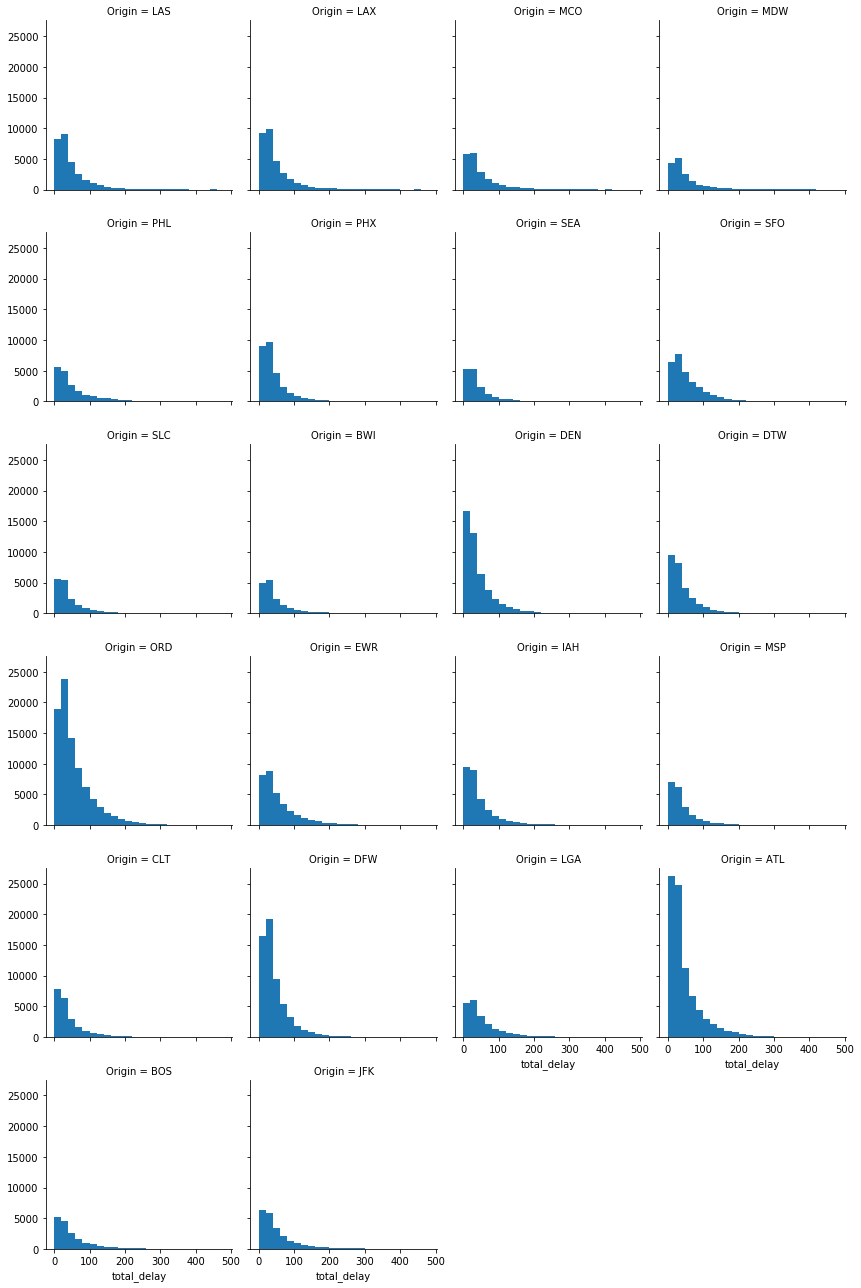

In [49]:
#distribution of delays by Origin

bins = np.arange(0.1,500,20)
g = sb.FacetGrid(data=df_origin, col='Origin', col_wrap=4)
g.map(plt.hist, 'total_delay',bins=bins);

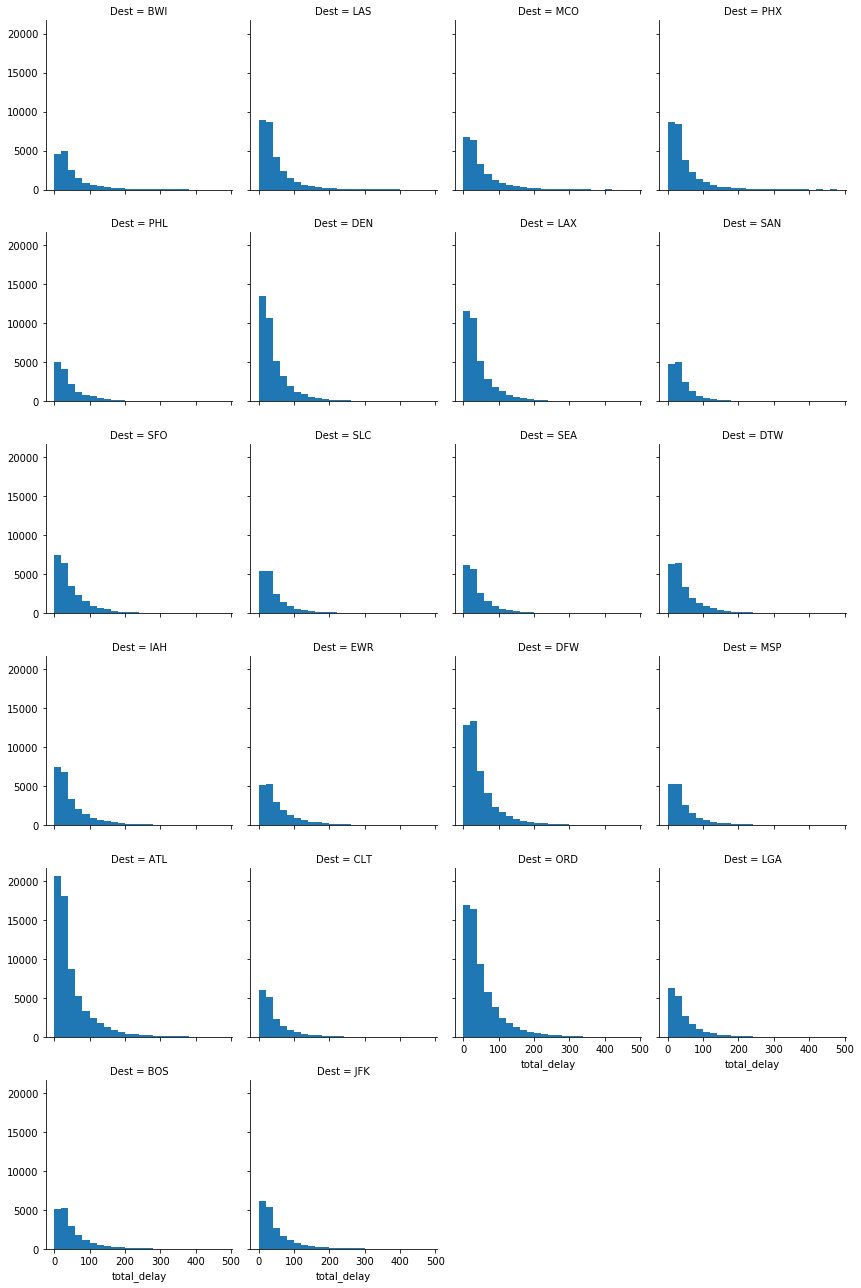

In [50]:
bins = np.arange(0.1,500,20)
g = sb.FacetGrid(data=df_dest, col='Dest', col_wrap=4)
g.map(plt.hist, 'total_delay',bins=bins);

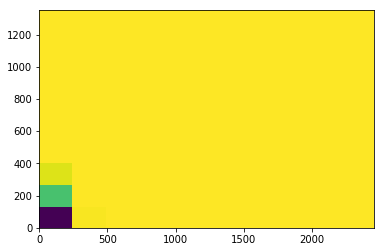

In [51]:
plt.hist2d(data = df_delays, x = 'total_delay', y = 'AirTime', cmap = 'viridis_r')
plt.colorbar;

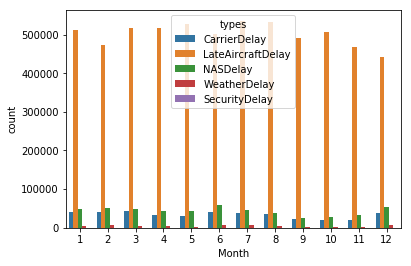

In [52]:
sb.countplot(data = df_new, x = 'Month', hue = 'types');

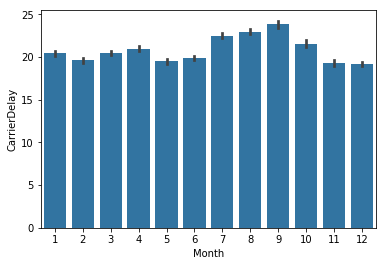

In [53]:
base_color = sb.color_palette()[0]

sb.barplot(data = df_delays, x = 'Month', y='CarrierDelay', color= base_color);

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

I observed some interesting relationships between frequency and length of delays and factors such as the carrier, cause of delay, airtime, departure times, distance, destination and origin of the flights. Through this analysis it became obvious which airports and airlines are notorious for delays. I also investigated relationships between delays and the time of year (month) and day of the week. 

### Were there any interesting or surprising interactions between features?

I was surprised to see that the majority of delays occured in February and April. February is not outrageous, but I would have expected more delays to happen during another winter month other than April. 